# Audio Analysis dengan Dynamic Time Warping (DTW)

Notebook ini berisi implementasi lengkap untuk:
1. Load audio dataset dari folder
2. Ekstraksi fitur audio menggunakan MFCC
3. Implementasi DTW dengan Euclidean distance
4. Visualisasi panjang audio
5. Visualisasi matriks DTW (cost matrix dan cumulative matrix)
6. Perhitungan jarak DTW antara data lama dan data baru

## 1. Import Libraries

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Librosa version: {librosa.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Librosa version: 0.11.0
NumPy version: 2.2.6


## 2. Fungsi Load Audio Dataset

In [2]:
def load_audio_dataset(dataset_path):
    """
    Load semua file audio dari dataset path.
    
    Parameters:
    -----------
    dataset_path : str
        Path ke folder dataset yang berisi file audio
    
    Returns:
    --------
    audio_data : list
        List berisi array numpy dari audio time series
    labels : list
        List berisi label/nama speaker
    file_paths : list
        List berisi path lengkap ke setiap file audio
    sample_rates : list
        List berisi sample rate dari setiap audio
    """
    audio_data = []
    labels = []
    file_paths = []
    sample_rates = []
    
    # Supported audio extensions
    audio_extensions = {'.wav', '.mp3', '.flac', '.ogg', '.m4a'}
    
    dataset_path = Path(dataset_path)
    
    if not dataset_path.exists():
        raise FileNotFoundError(f"Dataset path tidak ditemukan: {dataset_path}")
    
    print(f"Loading audio files from: {dataset_path}")
    print("-" * 60)
    
    # Iterate through all subdirectories and files
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = Path(root) / file
            
            # Check if file is audio
            if file_path.suffix.lower() in audio_extensions:
                try:
                    # Load audio file
                    audio, sr = librosa.load(file_path, sr=None)
                    
                    # Get label from parent directory name
                    label = Path(root).name
                    
                    audio_data.append(audio)
                    labels.append(label)
                    file_paths.append(str(file_path))
                    sample_rates.append(sr)
                    
                    duration = len(audio) / sr
                    print(f"✓ Loaded: {file_path.name}")
                    print(f"  Label: {label} | Duration: {duration:.2f}s | SR: {sr}Hz")
                    
                except Exception as e:
                    print(f"✗ Error loading {file_path.name}: {str(e)}")
    
    print("-" * 60)
    print(f"Total files loaded: {len(audio_data)}")
    print(f"Unique labels: {len(set(labels))} - {set(labels)}")
    
    return audio_data, labels, file_paths, sample_rates

## 3. Fungsi Ekstraksi Fitur MFCC

In [3]:
def extract_mfcc(audio, sr, n_mfcc=13, n_fft=2048, hop_length=512):
    """
    Ekstraksi fitur MFCC dari audio.
    
    Parameters:
    -----------
    audio : np.array
        Audio time series
    sr : int
        Sample rate
    n_mfcc : int
        Jumlah MFCC coefficients (default: 13)
    n_fft : int
        FFT window size (default: 2048)
    hop_length : int
        Hop length untuk STFT (default: 512)
    
    Returns:
    --------
    mfcc : np.array
        MFCC features dengan shape (n_mfcc, time_frames)
    """
    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length
    )
    
    # Transpose agar shape menjadi (time_frames, n_mfcc)
    return mfcc.T

def extract_all_mfcc(audio_data, sample_rates, n_mfcc=13):
    """
    Ekstraksi MFCC untuk semua audio dalam dataset.
    
    Parameters:
    -----------
    audio_data : list
        List berisi audio time series
    sample_rates : list
        List berisi sample rate
    n_mfcc : int
        Jumlah MFCC coefficients
    
    Returns:
    --------
    mfcc_features : list
        List berisi MFCC features untuk setiap audio
    """
    mfcc_features = []
    
    print("Extracting MFCC features...")
    print("-" * 60)
    
    for i, (audio, sr) in enumerate(zip(audio_data, sample_rates)):
        mfcc = extract_mfcc(audio, sr, n_mfcc=n_mfcc)
        mfcc_features.append(mfcc)
        print(f"Audio {i+1}: MFCC shape = {mfcc.shape}")
    
    print("-" * 60)
    print(f"MFCC extraction completed for {len(mfcc_features)} files")
    
    return mfcc_features

## 4. Implementasi DTW dengan Euclidean Distance

In [4]:
def dtw_distance(seq1, seq2, distance_metric=euclidean):
    """
    Implementasi Dynamic Time Warping (DTW) dengan Euclidean distance.
    
    Parameters:
    -----------
    seq1 : np.array
        Sequence pertama dengan shape (n_frames, n_features)
    seq2 : np.array
        Sequence kedua dengan shape (m_frames, n_features)
    distance_metric : function
        Fungsi untuk menghitung jarak (default: euclidean)
    
    Returns:
    --------
    dtw_dist : float
        Jarak DTW antara seq1 dan seq2
    cost_matrix : np.array
        Matriks cost (local distance)
    accumulated_cost : np.array
        Matriks cumulative cost
    path : list
        Optimal warping path
    """
    n, m = len(seq1), len(seq2)
    
    # Initialize cost matrix
    cost_matrix = np.zeros((n, m))
    
    # Calculate pairwise distances (local cost)
    for i in range(n):
        for j in range(m):
            cost_matrix[i, j] = distance_metric(seq1[i], seq2[j])
    
    # Initialize accumulated cost matrix
    accumulated_cost = np.zeros((n, m))
    accumulated_cost[0, 0] = cost_matrix[0, 0]
    
    # Fill first row
    for j in range(1, m):
        accumulated_cost[0, j] = accumulated_cost[0, j-1] + cost_matrix[0, j]
    
    # Fill first column
    for i in range(1, n):
        accumulated_cost[i, 0] = accumulated_cost[i-1, 0] + cost_matrix[i, 0]
    
    # Fill rest of the matrix
    for i in range(1, n):
        for j in range(1, m):
            accumulated_cost[i, j] = cost_matrix[i, j] + min(
                accumulated_cost[i-1, j],    # insertion
                accumulated_cost[i, j-1],    # deletion
                accumulated_cost[i-1, j-1]   # match
            )
    
    # Backtrack to find optimal path
    path = []
    i, j = n-1, m-1
    path.append((i, j))
    
    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            # Choose minimum of three predecessors
            min_cost = min(
                accumulated_cost[i-1, j],
                accumulated_cost[i, j-1],
                accumulated_cost[i-1, j-1]
            )
            
            if min_cost == accumulated_cost[i-1, j-1]:
                i -= 1
                j -= 1
            elif min_cost == accumulated_cost[i-1, j]:
                i -= 1
            else:
                j -= 1
        
        path.append((i, j))
    
    path.reverse()
    
    # DTW distance is the accumulated cost at the end
    dtw_dist = accumulated_cost[n-1, m-1]
    
    return dtw_dist, cost_matrix, accumulated_cost, path

## 5. Fungsi Visualisasi

In [5]:
def visualize_audio_lengths(audio_data, sample_rates, labels, file_paths):
    """
    Visualisasi panjang durasi semua audio dalam dataset.
    """
    durations = [len(audio) / sr for audio, sr in zip(audio_data, sample_rates)]
    
    plt.figure(figsize=(14, 6))
    
    # Bar plot
    plt.subplot(1, 2, 1)
    colors = plt.cm.viridis(np.linspace(0, 1, len(durations)))
    bars = plt.bar(range(len(durations)), durations, color=colors, edgecolor='black', linewidth=0.5)
    plt.xlabel('Audio Index', fontsize=12, fontweight='bold')
    plt.ylabel('Duration (seconds)', fontsize=12, fontweight='bold')
    plt.title('Audio Durations in Dataset', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, dur) in enumerate(zip(bars, durations)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{dur:.2f}s', ha='center', va='bottom', fontsize=9)
    
    # Box plot
    plt.subplot(1, 2, 2)
    plt.boxplot(durations, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', edgecolor='black'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'))
    plt.ylabel('Duration (seconds)', fontsize=12, fontweight='bold')
    plt.title('Duration Distribution', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "="*60)
    print("AUDIO DURATION STATISTICS")
    print("="*60)
    print(f"Total files: {len(durations)}")
    print(f"Mean duration: {np.mean(durations):.2f} seconds")
    print(f"Median duration: {np.median(durations):.2f} seconds")
    print(f"Min duration: {np.min(durations):.2f} seconds")
    print(f"Max duration: {np.max(durations):.2f} seconds")
    print(f"Std deviation: {np.std(durations):.2f} seconds")
    print("="*60)

def visualize_dtw_matrices(cost_matrix, accumulated_cost, path, title="DTW Matrices"):
    """
    Visualisasi cost matrix dan cumulative cost matrix dari DTW.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Cost Matrix (Local Distance)
    im1 = axes[0].imshow(cost_matrix, cmap='YlOrRd', aspect='auto', origin='lower')
    axes[0].set_title('Cost Matrix (Local Distance)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Sequence 2 (frames)', fontsize=12)
    axes[0].set_ylabel('Sequence 1 (frames)', fontsize=12)
    plt.colorbar(im1, ax=axes[0], label='Euclidean Distance')
    
    # Accumulated Cost Matrix with Path
    im2 = axes[1].imshow(accumulated_cost, cmap='viridis', aspect='auto', origin='lower')
    axes[1].set_title('Accumulated Cost Matrix with Optimal Path', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Sequence 2 (frames)', fontsize=12)
    axes[1].set_ylabel('Sequence 1 (frames)', fontsize=12)
    
    # Plot optimal path
    path_array = np.array(path)
    axes[1].plot(path_array[:, 1], path_array[:, 0], 'r-', linewidth=2, label='Optimal Path')
    axes[1].plot(path_array[:, 1], path_array[:, 0], 'wo', markersize=2)
    axes[1].legend(loc='upper left')
    
    plt.colorbar(im2, ax=axes[1], label='Cumulative Cost')
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def visualize_mfcc(mfcc, sr, title="MFCC Features"):
    """
    Visualisasi MFCC features.
    """
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(mfcc.T, sr=sr, x_axis='time', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB', label='MFCC Coefficient Value')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('MFCC Coefficients', fontsize=12)
    plt.tight_layout()
    plt.show()

## 6. Load Dataset

Sekarang kita akan load audio dataset dari path yang ditentukan.

In [6]:
# Path ke dataset
DATASET_PATH = r'c:/Users/achma/OneDrive/Documents/1Semester 5/PSD/speaker_datasets'

# Load audio dataset
audio_data, labels, file_paths, sample_rates = load_audio_dataset(DATASET_PATH)

Loading audio files from: c:\Users\achma\OneDrive\Documents\1Semester 5\PSD\speaker_datasets
------------------------------------------------------------
✓ Loaded: Buka1.wav
  Label: Harits | Duration: 2.38s | SR: 48000Hz
✓ Loaded: Buka10.wav
  Label: Harits | Duration: 2.14s | SR: 48000Hz
✓ Loaded: Buka11.wav
  Label: Harits | Duration: 2.96s | SR: 48000Hz
✓ Loaded: Buka12.wav
  Label: Harits | Duration: 2.68s | SR: 48000Hz
✓ Loaded: Buka13.wav
  Label: Harits | Duration: 2.56s | SR: 48000Hz
✓ Loaded: Buka14.wav
  Label: Harits | Duration: 2.80s | SR: 48000Hz
✓ Loaded: Buka15.wav
  Label: Harits | Duration: 2.56s | SR: 48000Hz
✓ Loaded: Buka16.wav
  Label: Harits | Duration: 3.12s | SR: 48000Hz
✓ Loaded: Buka17.wav
  Label: Harits | Duration: 2.40s | SR: 48000Hz
✓ Loaded: Buka18.wav
  Label: Harits | Duration: 2.72s | SR: 48000Hz
✓ Loaded: Buka19.wav
  Label: Harits | Duration: 3.16s | SR: 48000Hz
✓ Loaded: Buka2.wav
  Label: Harits | Duration: 2.78s | SR: 48000Hz
✓ Loaded: Buka20.wav

## 7. Visualisasi Panjang Audio

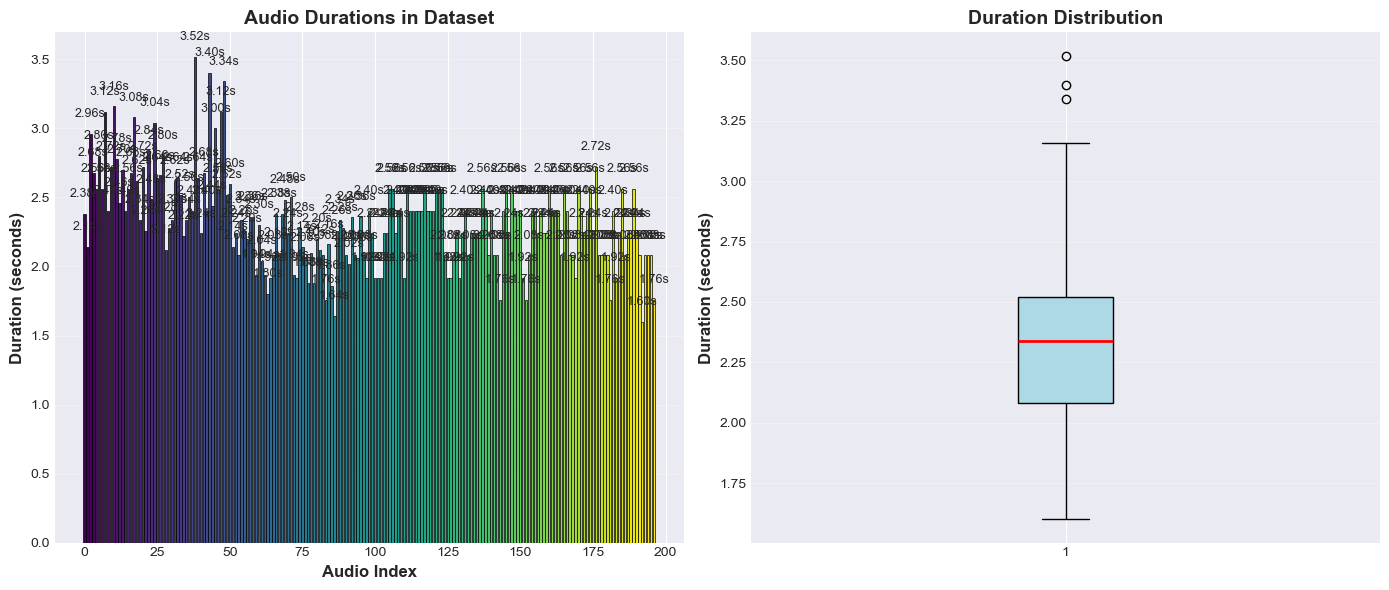


AUDIO DURATION STATISTICS
Total files: 197
Mean duration: 2.32 seconds
Median duration: 2.34 seconds
Min duration: 1.60 seconds
Max duration: 3.52 seconds
Std deviation: 0.32 seconds


In [7]:
# Visualisasi durasi audio
visualize_audio_lengths(audio_data, sample_rates, labels, file_paths)

## 8. Ekstraksi MFCC Features

In [8]:
# Ekstraksi MFCC untuk semua audio
N_MFCC = 13  # Jumlah MFCC coefficients
mfcc_features = extract_all_mfcc(audio_data, sample_rates, n_mfcc=N_MFCC)

Extracting MFCC features...
------------------------------------------------------------
Audio 1: MFCC shape = (224, 13)
Audio 2: MFCC shape = (201, 13)
Audio 3: MFCC shape = (278, 13)
Audio 4: MFCC shape = (252, 13)
Audio 5: MFCC shape = (241, 13)
Audio 6: MFCC shape = (263, 13)
Audio 7: MFCC shape = (241, 13)
Audio 8: MFCC shape = (293, 13)
Audio 9: MFCC shape = (226, 13)
Audio 10: MFCC shape = (256, 13)
Audio 11: MFCC shape = (297, 13)
Audio 12: MFCC shape = (261, 13)
Audio 13: MFCC shape = (231, 13)
Audio 14: MFCC shape = (254, 13)
Audio 15: MFCC shape = (226, 13)
Audio 16: MFCC shape = (241, 13)
Audio 17: MFCC shape = (252, 13)
Audio 18: MFCC shape = (289, 13)
Audio 19: MFCC shape = (246, 13)
Audio 20: MFCC shape = (220, 13)
Audio 21: MFCC shape = (256, 13)
Audio 22: MFCC shape = (212, 13)
Audio 23: MFCC shape = (267, 13)
Audio 24: MFCC shape = (233, 13)
Audio 25: MFCC shape = (286, 13)
Audio 26: MFCC shape = (248, 13)
Audio 27: MFCC shape = (250, 13)
Audio 28: MFCC shape = (263, 

## 9. Visualisasi MFCC Features (Sample)

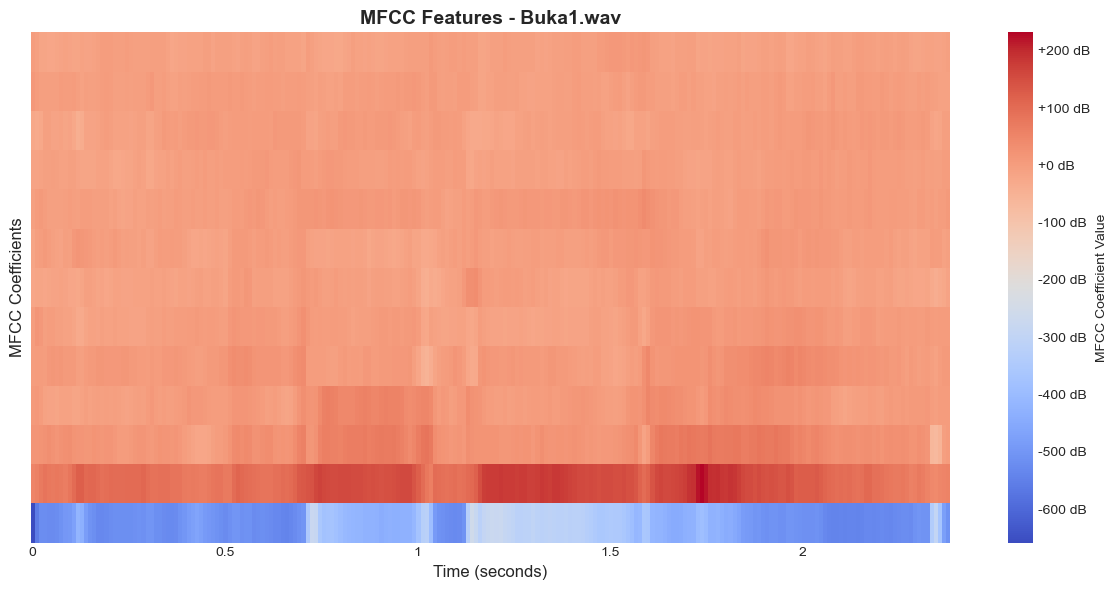

In [9]:
# Visualisasi MFCC untuk audio pertama sebagai contoh
if len(mfcc_features) > 0:
    visualize_mfcc(mfcc_features[0], sample_rates[0], 
                   title=f"MFCC Features - {Path(file_paths[0]).name}")

## 10. Perhitungan DTW Distance

Sekarang kita akan menghitung jarak DTW antara semua pasangan audio.

In [10]:
def calculate_dtw_matrix(mfcc_features, labels, file_paths):
    """
    Hitung DTW distance untuk semua pasangan audio.
    """
    n = len(mfcc_features)
    dtw_matrix = np.zeros((n, n))
    
    print("Calculating DTW distances...")
    print("="*60)
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                dtw_matrix[i, j] = 0
            else:
                dtw_dist, _, _, _ = dtw_distance(mfcc_features[i], mfcc_features[j])
                dtw_matrix[i, j] = dtw_dist
                dtw_matrix[j, i] = dtw_dist
                
                file1 = Path(file_paths[i]).name
                file2 = Path(file_paths[j]).name
                print(f"DTW({i}, {j}): {file1} <-> {file2} = {dtw_dist:.2f}")
    
    print("="*60)
    print("DTW calculation completed!")
    
    return dtw_matrix

# Hitung DTW matrix
dtw_matrix = calculate_dtw_matrix(mfcc_features, labels, file_paths)

Calculating DTW distances...
DTW(0, 1): Buka1.wav <-> Buka10.wav = 13932.21
DTW(0, 2): Buka1.wav <-> Buka11.wav = 14886.59
DTW(0, 3): Buka1.wav <-> Buka12.wav = 14476.27
DTW(0, 4): Buka1.wav <-> Buka13.wav = 13366.97
DTW(0, 5): Buka1.wav <-> Buka14.wav = 14008.29
DTW(0, 6): Buka1.wav <-> Buka15.wav = 12585.60
DTW(0, 7): Buka1.wav <-> Buka16.wav = 13629.38
DTW(0, 8): Buka1.wav <-> Buka17.wav = 15483.06
DTW(0, 9): Buka1.wav <-> Buka18.wav = 15582.71
DTW(0, 10): Buka1.wav <-> Buka19.wav = 15944.80
DTW(0, 11): Buka1.wav <-> Buka2.wav = 11611.94
DTW(0, 12): Buka1.wav <-> Buka20.wav = 12774.86
DTW(0, 13): Buka1.wav <-> Buka21.wav = 15227.86
DTW(0, 14): Buka1.wav <-> Buka22.wav = 14726.97
DTW(0, 15): Buka1.wav <-> Buka23.wav = 14414.08
DTW(0, 16): Buka1.wav <-> Buka24.wav = 12745.63
DTW(0, 17): Buka1.wav <-> Buka25.wav = 15603.43
DTW(0, 18): Buka1.wav <-> Buka26.wav = 15206.92
DTW(0, 19): Buka1.wav <-> Buka27.wav = 14580.95
DTW(0, 20): Buka1.wav <-> Buka28.wav = 15422.83
DTW(0, 21): Buka1.wav

## 11. Visualisasi DTW Distance Matrix

## 12. Analisis DTW Detail untuk Pasangan Tertentu

Pilih dua audio untuk analisis DTW yang lebih detail dengan visualisasi matriks.

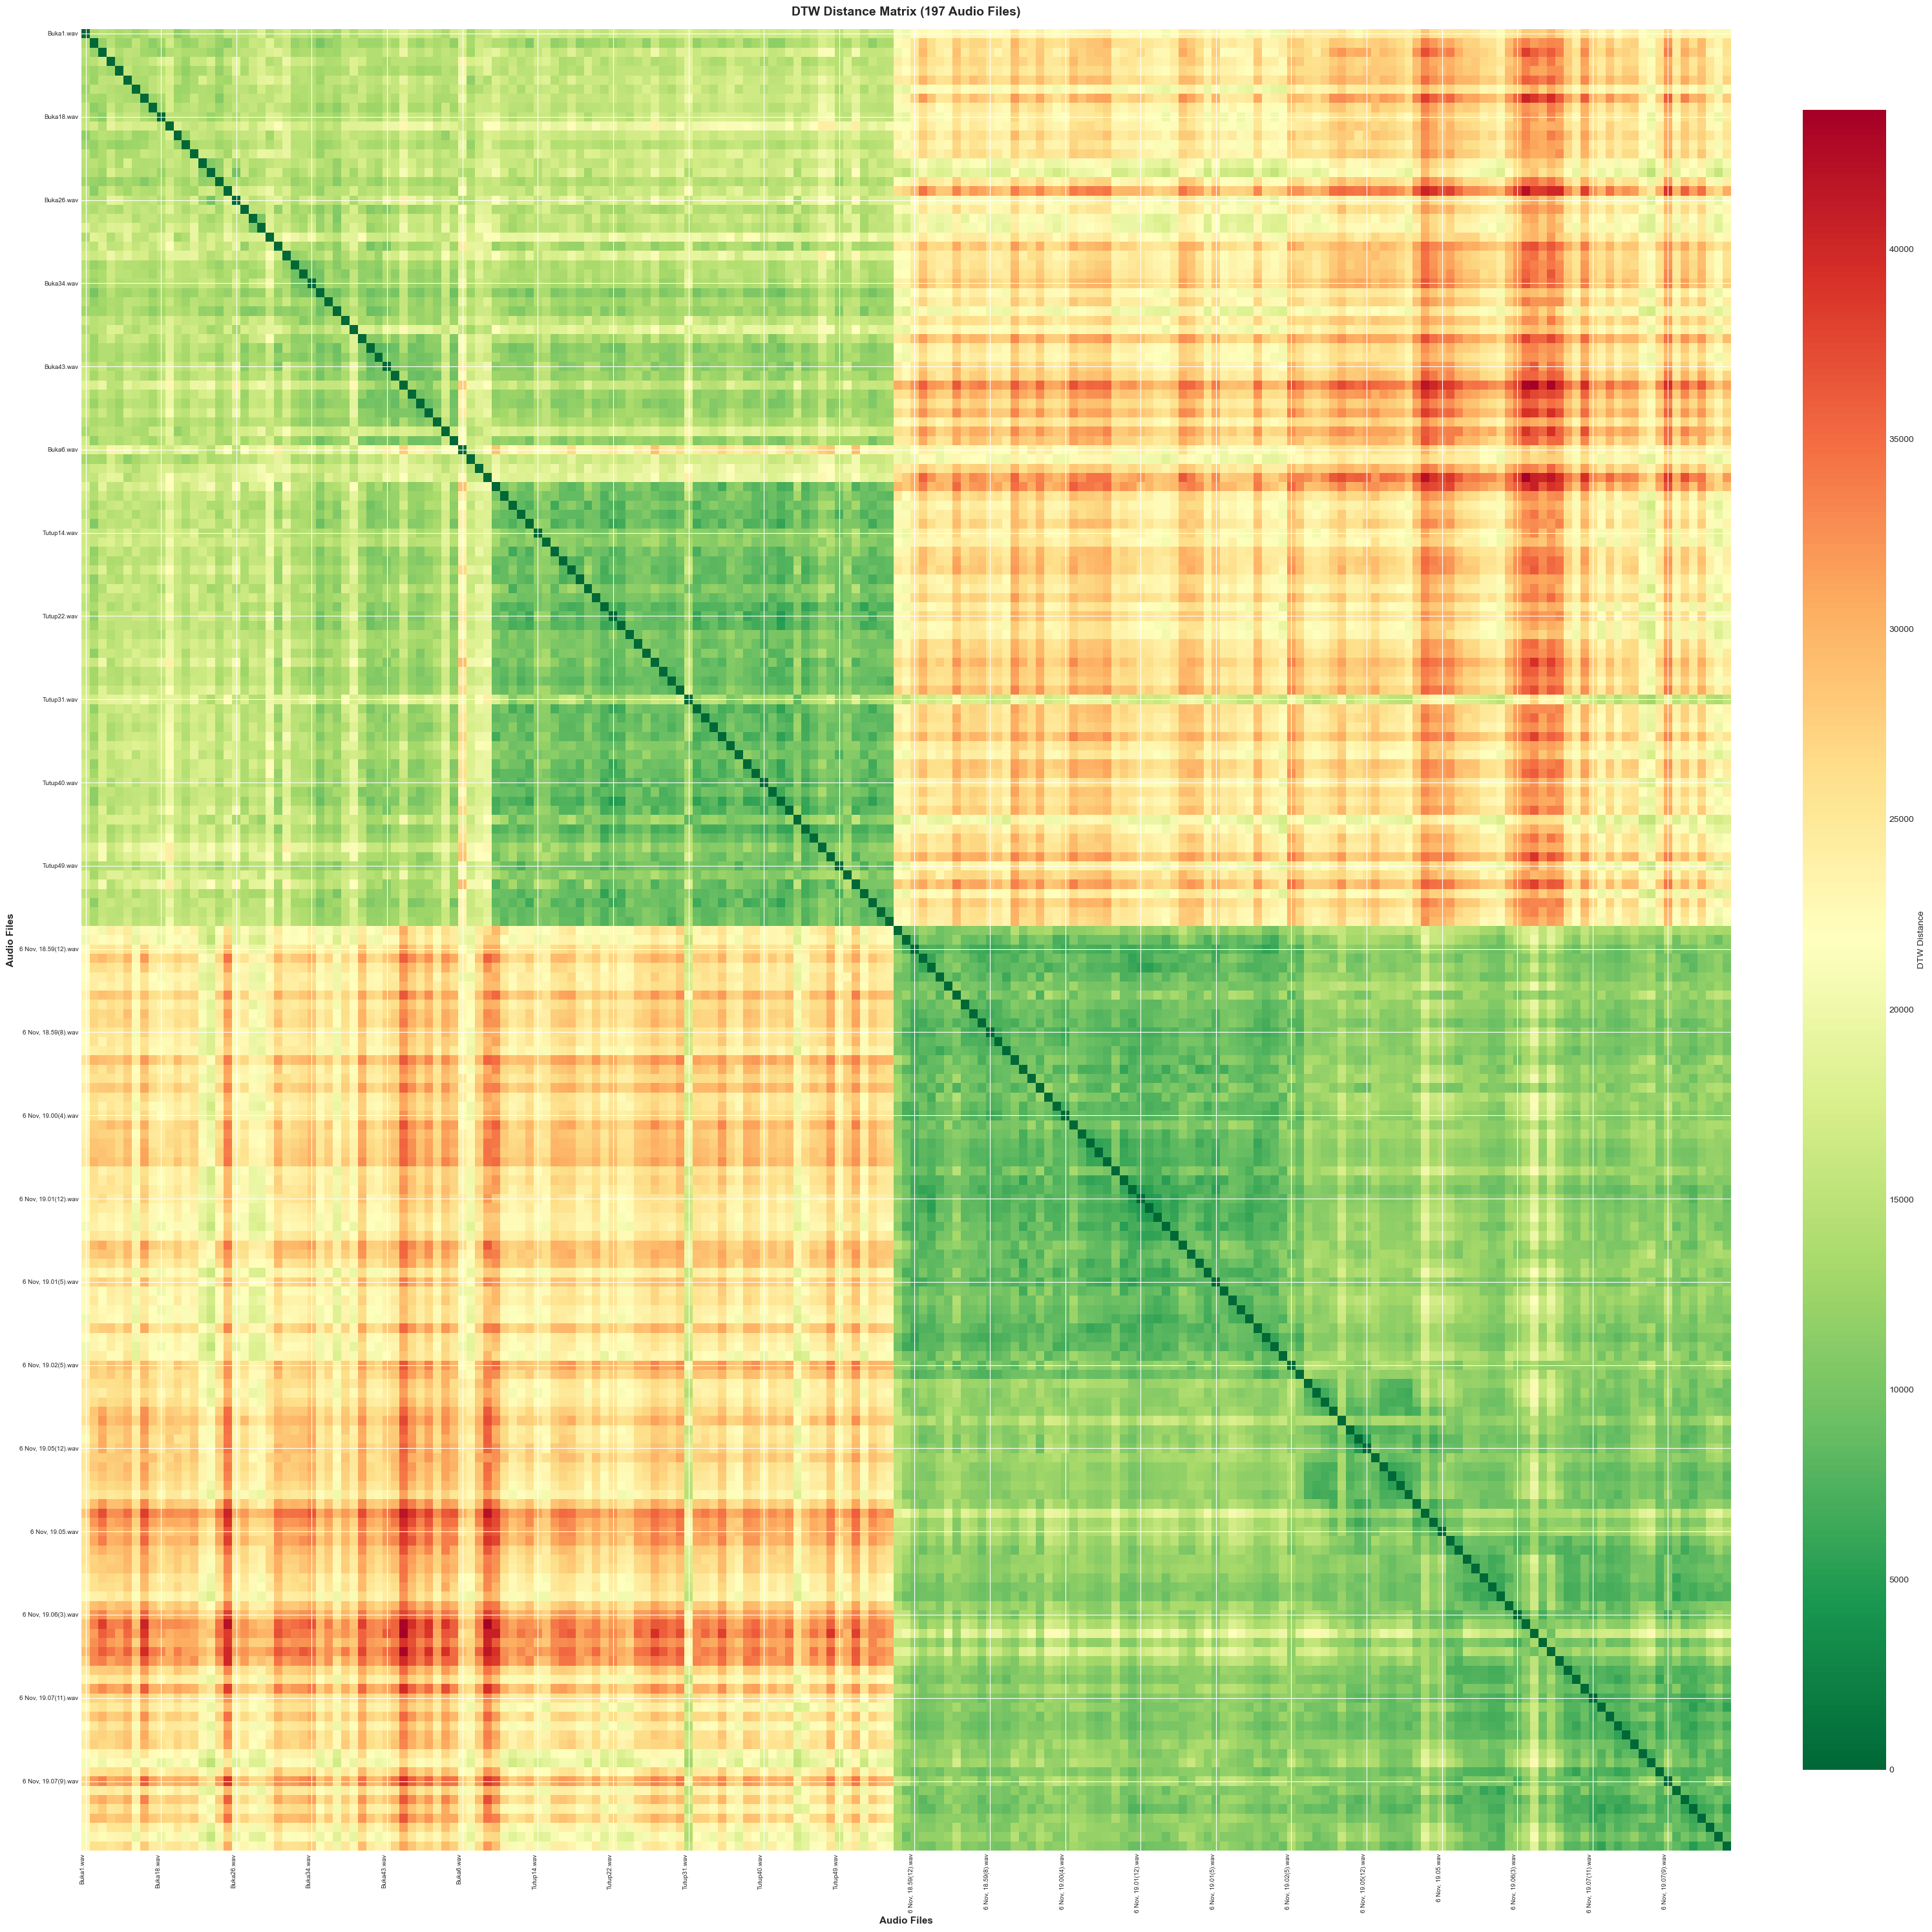


DTW DISTANCE MATRIX STATISTICS
Number of audio files: 197
Total comparisons: 19306
Mean DTW distance: 19316.27
Median DTW distance: 19540.79
Min DTW distance: 4791.14
Max DTW distance: 43665.46
Std deviation: 7702.71


In [31]:
# Visualisasi DTW distance matrix - IMPROVED VERSION
n_files = len(file_paths)
file_names = [Path(fp).name for fp in file_paths]

# Sesuaikan ukuran figure berdasarkan jumlah file
fig_size = max(12, min(n_files * 0.3, 30))  # Min 12, Max 30
plt.figure(figsize=(fig_size, fig_size))

# Create heatmap
im = plt.imshow(dtw_matrix, cmap='RdYlGn_r', aspect='auto', interpolation='nearest')
cbar = plt.colorbar(im, label='DTW Distance', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)

# Untuk dataset besar, tampilkan label setiap N file
step = max(1, n_files // 20)
tick_indices = list(range(0, n_files, step))
tick_labels = [file_names[i] for i in tick_indices]

plt.xticks(tick_indices, tick_labels, rotation=90, ha='right', fontsize=7)
plt.yticks(tick_indices, tick_labels, fontsize=7)

plt.title(f'DTW Distance Matrix ({n_files} Audio Files)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Audio Files', fontsize=11, fontweight='bold')
plt.ylabel('Audio Files', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistik
print("\n" + "="*60)
print("DTW DISTANCE MATRIX STATISTICS")
print("="*60)
non_diag_values = dtw_matrix[~np.eye(n_files, dtype=bool)]
print(f"Number of audio files: {n_files}")
print(f"Total comparisons: {n_files * (n_files - 1) // 2}")
print(f"Mean DTW distance: {np.mean(non_diag_values):.2f}")
print(f"Median DTW distance: {np.median(non_diag_values):.2f}")
print(f"Min DTW distance: {np.min(non_diag_values):.2f}")
print(f"Max DTW distance: {np.max(non_diag_values):.2f}")
print(f"Std deviation: {np.std(non_diag_values):.2f}")
print("="*60)

## 13. Perbandingan Data Lama vs Data Baru

Jika Anda memiliki data lama dan data baru yang ingin dibandingkan, gunakan cell berikut.

In [32]:
def compare_old_vs_new(mfcc_features, labels, file_paths, old_label, new_label):
    """
    Bandingkan audio dengan label 'old' vs 'new'.
    """
    # Filter berdasarkan label
    old_indices = [i for i, label in enumerate(labels) if old_label.lower() in label.lower()]
    new_indices = [i for i, label in enumerate(labels) if new_label.lower() in label.lower()]
    
    if not old_indices or not new_indices:
        print(f"Error: Tidak ditemukan audio dengan label '{old_label}' atau '{new_label}'")
        print(f"Available labels: {set(labels)}")
        return
    
    print(f"Found {len(old_indices)} audio(s) with label '{old_label}'")
    print(f"Found {len(new_indices)} audio(s) with label '{new_label}'")
    print("\n" + "="*60)
    
    # Hitung DTW untuk semua kombinasi old vs new
    results = []
    
    for old_idx in old_indices:
        for new_idx in new_indices:
            dtw_dist, _, _, _ = dtw_distance(mfcc_features[old_idx], mfcc_features[new_idx])
            
            old_file = Path(file_paths[old_idx]).name
            new_file = Path(file_paths[new_idx]).name
            
            results.append({
                'old_idx': old_idx,
                'new_idx': new_idx,
                'old_file': old_file,
                'new_file': new_file,
                'dtw_distance': dtw_dist
            })
            
            print(f"DTW: {old_file} <-> {new_file} = {dtw_dist:.2f}")
    
    print("="*60)
    
    # Statistik
    distances = [r['dtw_distance'] for r in results]
    print(f"\nStatistics for '{old_label}' vs '{new_label}':")
    print(f"  Mean DTW distance: {np.mean(distances):.2f}")
    print(f"  Min DTW distance: {np.min(distances):.2f}")
    print(f"  Max DTW distance: {np.max(distances):.2f}")
    print(f"  Std deviation: {np.std(distances):.2f}")
    
    return results

# Contoh penggunaan: bandingkan audio dengan label 'old' dan 'new'
# Sesuaikan dengan nama folder/label Anda
OLD_LABEL = 'old'  # Ganti dengan label data lama
NEW_LABEL = 'new'  # Ganti dengan label data baru

# Uncomment baris berikut jika ingin membandingkan
# comparison_results = compare_old_vs_new(mfcc_features, labels, file_paths, OLD_LABEL, NEW_LABEL)

## 14. Export Results

Simpan hasil DTW distance matrix ke file CSV.

In [14]:
import pandas as pd

# Create DataFrame
file_names = [Path(fp).name for fp in file_paths]
dtw_df = pd.DataFrame(dtw_matrix, columns=file_names, index=file_names)

# Save to CSV
output_path = Path(DATASET_PATH).parent / 'dtw_distance_matrix.csv'
dtw_df.to_csv(output_path)

print(f"DTW distance matrix saved to: {output_path}")
print("\nPreview:")
print(dtw_df)

DTW distance matrix saved to: c:\Users\achma\OneDrive\Documents\1Semester 5\PSD\dtw_distance_matrix.csv

Preview:
                         Buka1.wav    Buka10.wav    Buka11.wav    Buka12.wav  \
Buka1.wav                 0.000000  13932.210438  14886.593144  14476.265796   
Buka10.wav            13932.210438      0.000000  12126.555218  14697.567930   
Buka11.wav            14886.593144  12126.555218      0.000000  16661.629078   
Buka12.wav            14476.265796  14697.567930  16661.629078      0.000000   
Buka13.wav            13366.966120  12564.614604  13861.080751  12959.923923   
...                            ...           ...           ...           ...   
6 Nov, 19.08​(3).wav  23083.494171  25970.241013  27958.852432  25043.807457   
6 Nov, 19.08​(4).wav  23304.349934  29341.660362  29231.149944  27766.293419   
6 Nov, 19.08​(5).wav  22518.572279  24567.109011  23047.550770  25324.853306   
6 Nov, 19.08​(6).wav  20926.294142  23093.235504  21359.792088  22989.258739   
6 Nov,

## 15. Summary

Notebook ini telah mendemonstrasikan:

1. ✅ Loading audio dataset dari folder
2. ✅ Ekstraksi fitur MFCC dari audio
3. ✅ Implementasi DTW dengan Euclidean distance
4. ✅ Visualisasi panjang audio
5. ✅ Visualisasi cost matrix dan cumulative cost matrix
6. ✅ Perhitungan jarak DTW untuk semua pasangan audio
7. ✅ Perbandingan data lama vs data baru
8. ✅ Export hasil ke CSV

### Cara Penggunaan:

1. Pastikan dataset audio Anda terorganisir dalam folder (bisa dengan subfolder untuk setiap speaker/label)
2. Update `DATASET_PATH` dengan path ke folder dataset Anda
3. Jalankan semua cell secara berurutan
4. Untuk analisis detail, ubah nilai `idx1` dan `idx2` di Section 12
5. Untuk perbandingan old vs new, uncomment dan sesuaikan Section 13

### Dependencies:

```bash
pip install numpy librosa matplotlib seaborn scipy pandas
```